In [1]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gym

## Deep Neural Network

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


## Agent-brain

In [3]:
class PolicyGradientAgent():
    def __init__(self, lr, input_dims, gamma=0.99, n_actions=4):
        self.gamma = gamma
        self.lr = lr
        self.reward_memory = []
        self.action_memory = []

        self.policy = PolicyNetwork(self.lr, input_dims, n_actions)

    def choose_action(self, observation):
        state = T.Tensor([observation]).to(self.policy.device)
        probabilities = F.softmax(self.policy.forward(state), dim=1)
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        self.action_memory.append(log_probs)

        return action.item()

    def store_rewards(self, reward):
        self.reward_memory.append(reward)

    def train(self):
        self.policy.optimizer.zero_grad()
        

        G = np.zeros_like(self.reward_memory, dtype=np.float64)
        for t in range(len(self.reward_memory)):
            G_sum = 0
            discount = 1
            for k in range(t, len(self.reward_memory)):
                G_sum += self.reward_memory[k] * discount
                discount *= self.gamma
            G[t] = G_sum
        G = T.tensor(G, dtype=T.float).to(self.policy.device)
        
        
        
        loss = 0
        for g, logprob in zip(G, self.action_memory):
            loss += -g * logprob
        loss.backward()
        self.policy.optimizer.step()

        self.action_memory = []
        self.reward_memory = []

## Main Loop for LunarLander-v2

In [4]:
env = gym.make('LunarLander-v2')
n_games = 1200
agent = PolicyGradientAgent(gamma=0.99, lr=0.0003, input_dims=[8],
                            n_actions=4)

scores,avg_score = [], []
for i in range(n_games):
    done = False
    observation = env.reset()
    score = 0
    while not done:
        env.render()
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_rewards(reward)
        observation = observation_
    agent.train()
    scores.append(score)

    running_avg_score = np.mean(scores[-100:])
    avg_score.append(running_avg_score)
    
    print('Episode ', i, 'Score %.2f' % score,
            'Running Average Score %.2f' % running_avg_score)
    


Episode  0 Score -124.72 Running Average Score -124.72
Episode  1 Score -172.17 Running Average Score -148.44
Episode  2 Score -219.70 Running Average Score -172.20
Episode  3 Score -216.69 Running Average Score -183.32
Episode  4 Score -69.67 Running Average Score -160.59
Episode  5 Score -126.26 Running Average Score -154.87
Episode  6 Score -48.96 Running Average Score -139.74
Episode  7 Score -314.06 Running Average Score -161.53
Episode  8 Score -92.03 Running Average Score -153.81
Episode  9 Score -243.54 Running Average Score -162.78
Episode  10 Score -233.38 Running Average Score -169.20
Episode  11 Score -324.39 Running Average Score -182.13
Episode  12 Score -151.27 Running Average Score -179.76
Episode  13 Score -79.72 Running Average Score -172.61
Episode  14 Score -109.28 Running Average Score -168.39
Episode  15 Score -131.36 Running Average Score -166.07
Episode  16 Score -557.69 Running Average Score -189.11
Episode  17 Score -290.17 Running Average Score -194.72
Episod

## Plot Avg. Rewards/Episodes

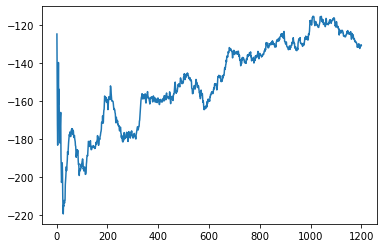

In [5]:
import seaborn as sns
x = [i+1 for i in range(n_games)]
sns.lineplot(x,avg_score)        